## Reading notes
### https://cs.stanford.edu/people/dorarad/mac/blog.html
A neural network learns a direct mapping from input to output, but lacks a good understanding of that mapping. If we change some details in the input, it doesn't work anymore.

They are trying to come up with the general-purpose unit for reasoning. Is it enough with control and memory? 

"Finally, aiming to retrieve information that is relevant for the reasoning operation c_i, we measure its similarity to each of the interactions I_{i,h,w}." Does that make sense? Why does the information required for one reasoning operation have to be similar to the operation itself?

Note that the authors use a shared state, instead of using stateful nns. This improvement is worth trying.

Three units
* input unit: create a good distributed representation. For words: first we translate to word-embeddings, then we translate we add context to each word.
* recurrent unit:
    * Control: 
        * we want to extract the desired operation. We need to keep track of the past operation, because that seems to help in doing long-term processing. Also, we want to see the global task we are trying to solve. In a QA task, we want to see the whole text of a question. So the first operation is to combine the past operation c_{i-1} with the whole text of the question, biased towards step i. This tells us what operation we are trying to do.
        * Then, we change the basis of the result from above to a linear combination of the words in the question. This acts as a regularizer (and it's also helpful for interpretability.) (A valid output from this unit could be: actual object := object that is to the right of the actual object. Another could be to create a new identity, object2 := object that has the same color as object1. .)
    * Read:
        * we want to retrieve selectively from our knowledge base and the memory from the last iteration. Thus, we attend the knowledge base based on (a) the knowledge base, (b) control output, (c) previous memory output.
        * steps
            * To do this, we compute the interaction between the knowledge base and the previous memory output to see if there are things that are important from the knowledge base in light of the previous memory output.
            * Then, we concatenate the result of that interaction with the knowledge base, to have a fresh version of the kb if the task requires it.
            * Then, we concatenate the (interaction + kb) with the control output. Then we pass that information through a neural net to decide the attention weights on the kb. 
        * in other words, we input a neural net (a) the kb, (b) the interaction of kb and previous memory, and (c) the control output. Then, that nn decides what to look at the kb.
    * Write
        * we already computed the new bit of memory r_i in the read unit. However, we would lose information if we just keep r_i. That's why we use the write unit. We want to integrate the new r_i bit of memory with the previous memory, and remain in the same space. That means we need at least one gate 
        * steps
            * we know what we want to combine: the whole memory so far and the new bit of memory. Thus, we concatenate both things and pass the result through a nn.
            * self-attention: we compute the similarity between the actual control bit and all the previous control bits. We take that distribution and then we create the weighted average of the memory bits (thus, we will give more importance to the memory bits that had similar control bit to our actual control bit.) Then, we concatenate that average to m_i^{prev} and pass it through a nn. (Why isn't it enough to concatenate them? Possible answer: we want a better representation of the data.)
            * what if we don't need so many steps? We have a gate that conditioned on the control unit, we can just let the previous memory go through without interacting with all the computed so far. (useful if our task is simple and to avoid vanishing gradients.)
          
* output unit

{TODO: try visualizing the value of the gate in the write unit. does it saturate to 0 or 1, or it tends to be between 0.3 and 0.7?}
{TODO: think/try of models that are recursive, so we can invoke (poke) a new set of reasoning units while are are in the origin sequence of processing. }
{TODO: I think that the kb here is small. It gets interesting when you have much more information. The problem there seems to be accessing it (attention is inefficient.) So we can try recursion or other methods.}

We have four basic operations
* Concatenation(x, y): it doesn't add interactions. 
* Feedfoward_NN(x): computes a better representation of x  
* Elementwise product(x, y): measures the interaction between x and y
* Attention(a, x): computes a weighted version of x. 

Everything is differentiable!
* softmax: argmax
* softmax with values powered: argmax 
* gates / k * f + (1 - k) * g: logical or?

Concepts:
attention: 
* input: $V, U \in R^{m \times n}$ and $q \in R^n$
* process:
    * $w = softargmax(Vq)$
    * $r = w^TU$
* output: $r$
self-attention: when q is from the same distribution as V.
hard-attention: producing either 1 or 0 for the values of w.
input: two vectors and a query value. We dot product the value of one vector with the query value. That gives us a set of weights which 

### https://arxiv.org/pdf/1410.5401.pdf
Addressing mechanisms
* Content-based memories (like hopfield networks): the controller produces an approximation of the memory and compares it with the storage to recover the exact memory. 
* Location-based memories: the content of the memory can be arbitrary. For instance, if we want to calculate the multiplying operation, the two numbers we multiply are arbitrary.
Implementation of memory
* Content-based: compute the cosine similarity between the actual memory and the memory we want to retrive. Then, we apply a softmax over all the similarities.
* Location-based:
    * gate: before going to the location-based memory, we apply a gate in the content-based memory we just generated. This allows us to
        * Erase content-based memory: we can apply a shift in the previous memory, $w_{t-1}$
        * Keep content-based memory: we can apply a shift in the content-based memory
        * Don't shift: we get the content-based working on its own
    * shift: the controller defines a shift vector, $s_t.$ Then, for each element $w_t(i)$ in the memory we go through every element $w^g_t(j)$ and we add accordingly to $s_t(i - j).$ What does the $i - j$ mean? It means that the first element in $s_t$ corresponds to a shift of zero (ie when i == j.) If we go to the right of $s_t$, we have the shifts 1, 2, ..., and if we go the left, we have the shifts -1, -2, ...
    * softmax: the shift may disperse the weights, so we apply a softmax. (we potentiate the values before applying softmax so as to make the weights sharper)
    
The interpolation between the previous attention and current generated attention is only a scalar? If so, why isn't it a vector with dims memory-size?

#### https://arxiv.org/pdf/1807.08518.pdf
Controller:
* either a feedforward or a recurrent nn
* it outputs b, 

Next: Graves et al. (2014; 2016) cosine similarity
Recursion on hopfield nets

# FUR-THER things to try
if it's accessing memory, then it shouldn't matter what we put in the memory. As a test of generalizing, change the range (and distribution) of the values that we store in the memory.

interestinggg: merging memories. does humans retrieve two memories at the same time, merged? or we just have only one defined memory? (this is similar to that feeling at night I have of having two thoughts at the same time)

recursive hopfield net

implement NTM or MAC.

In [287]:
import tensorflow as tf
import numpy as np

def binary_to_int(bitlist):
    out = 0
    for bit in bitlist:
        out = (out << 1) | bit
    return out

def ps(a1, a2=None):
    print(np.shape(a1))
    if type(a2) != type(None): 
        print(np.shape(a2))

batch_size = 128
input_length = 4
memory_length = 16
learning_rate = 1e-4
train_size = 500

ms = np.random.randint(0, 1000, size=(memory_length, 1)) 
xs = np.random.randint(0, 2, size=(train_size, input_length))
ys = [ms[binary_to_int(xi)] for xi in xs]

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [batch_size, input_length])
y = tf.placeholder(tf.float32, [batch_size, 1])
m = tf.placeholder(tf.float32, [memory_length, 1])
w = tf.Variable(tf.random_normal((input_length, memory_length), stddev=.1))
b = tf.Variable(tf.zeros((memory_length)))

a = tf.nn.softmax(tf.matmul(x, w) + b)
out = tf.tensordot(a, m, 1)

loss = tf.losses.mean_squared_error(y, out)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
minimize = optimizer.minimize(loss)

tr_loss, n = {}, 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        #Comment line below for section 1
        #if i % 1000 == 0:
        #    ms = np.random.randint(0, 1000, size=(16, 1))
        x_batch = xs[n:n + batch_size]
        y_batch = np.array(ys[n:n + batch_size]).reshape(-1, 1)    
        n = (n + batch_size) % (train_size - batch_size)
        tr_loss[i], _ = sess.run([loss, minimize], feed_dict={x: x_batch, y: y_batch, m: ms})
        if i % 1000 == 0: print(i, tr_loss[i])
    w_final, b_final = sess.run([w, b])

0 69889.4
1000 73267.4
2000 66975.6
3000 58761.6


KeyboardInterrupt: 

# Section 1: no dynamic memory

MSE: 2432.60380228
Correlation [ 6134851.65430207]


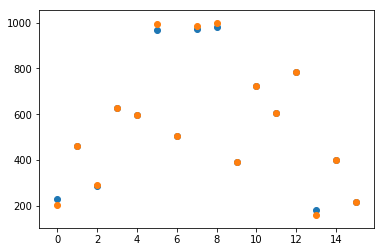

In [134]:
import matplotlib.pyplot as plt

softargmax = lambda x: np.exp(x - max(x)) / sum(np.exp(x - max(x)))

def int_to_binary(n):
    return [int(digit) for digit in bin(n)[2:]]

def plot_preds():
    pred = np.zeros((16,))
    for i in range(16):
        bits = int_to_binary(i)
        bits = np.pad(bits, (4 - len(bits), 0), 'constant', constant_values=(0, 0)) # add remainign bits)
        v = softargmax(np.dot(bits, w_final) + b_final)
        pred[i] = v.dot(ms)

    real = [ms[i][0] for i in range(16)]
    print('MSE:', np.sum(np.square(pred - real)))
    print('Correlation', np.correlate(pred, real))
    plt.scatter(np.arange(16), pred)
    plt.scatter(np.arange(16), real)

plot_preds()

Nicy, huh? Based on the results above, it seems it learned to answer questions regarding the value of the memory. Now, did it really learned to look up at the memory, or it just has the hardcoded values? We can answer our question changing the values of our memory.

In [216]:
argmaxs = np.zeros((16,))
for i in range(16):
    bits = int_to_binary(i)
    bits = np.pad(bits, (4 - len(bits), 0), 'constant', constant_values=(0, 0)) # add remainign bits)
    print(i, list(reversed(np.argsort(np.dot(bits, w_final) + b_final))))

0 [8, 12, 2, 9, 4, 14, 13, 3, 15, 10, 7, 1, 11, 6, 5, 0]
1 [3, 12, 6, 5, 8, 11, 14, 2, 9, 4, 13, 7, 1, 10, 15, 0]
2 [3, 11, 15, 6, 9, 13, 12, 14, 2, 10, 5, 8, 7, 4, 0, 1]
3 [3, 6, 11, 12, 5, 15, 9, 14, 8, 13, 2, 10, 7, 4, 0, 1]
4 [1, 9, 5, 11, 13, 10, 2, 8, 7, 4, 15, 12, 14, 3, 0, 6]
5 [5, 1, 11, 9, 3, 12, 6, 8, 13, 10, 7, 2, 14, 4, 15, 0]
6 [11, 9, 5, 1, 3, 15, 13, 10, 2, 6, 7, 14, 12, 4, 0, 8]
7 [5, 11, 3, 9, 6, 12, 1, 15, 13, 10, 2, 7, 14, 8, 0, 4]
8 [8, 1, 15, 6, 5, 12, 2, 4, 9, 10, 14, 13, 7, 3, 11, 0]
9 [8, 6, 5, 1, 12, 3, 15, 11, 14, 2, 9, 4, 10, 7, 13, 0]
10 [15, 6, 8, 11, 1, 3, 5, 9, 12, 2, 13, 14, 10, 7, 4, 0]
11 [6, 3, 5, 8, 15, 11, 12, 1, 9, 14, 2, 13, 10, 7, 0, 4]
12 [1, 5, 8, 9, 15, 11, 6, 10, 13, 2, 7, 4, 12, 0, 14, 3]
13 [1, 5, 8, 6, 11, 9, 12, 15, 3, 10, 13, 7, 2, 4, 14, 0]
14 [1, 5, 11, 15, 9, 6, 8, 3, 13, 10, 2, 7, 12, 0, 14, 4]
15 [5, 6, 1, 11, 3, 15, 8, 9, 12, 13, 10, 2, 7, 0, 14, 4]


MSE: 2394604.2156
Correlation [ 4859359.04562399]


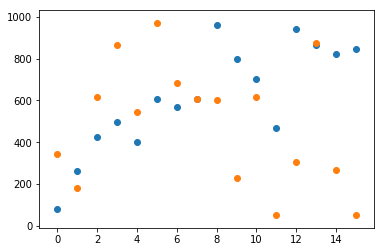

In [182]:
ms = np.random.randint(0, 1000, size=(16, 1))
plot_preds()

It seems there could be some correlation. First, let's visualize two random set of 15 points to understand whether we have something in the plot above or not. Second, let's try the neural net with changes in memory, so it can generalize to cases like the one above.

MSE: 2948643
Correlation [4222769]


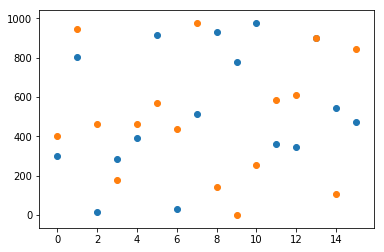

In [183]:
pred = np.random.randint(0, 1000, size=(16))
real = np.random.randint(0, 1000, size=(16))
plt.scatter(np.arange(16), pred)
plt.scatter(np.arange(16), real)
print('MSE:', np.sum(np.square(pred - real)))
print('Correlation', np.correlate(pred, real))

It seems that there is _some_ information the neural net is learning to extract, but not that much. 

# Section 2: dynamic memory
It seems the neural net was overfitting to the values of the memory. In other words, it seems it wasn't using the memory at all. There are two ways we can improve this. 

1) we reset the memory every some steps

2) we make the memory so large that the only option left for the neural net is to use it. We are 

Let's try the first one. But before that, let's understand what we are doing. We want to make a neural net learn how to use its memory. A first task could be to learn to access a memory given its position. It seems weird, though. How knowing the position of the memory differs from knowing the memory itself? If we consider our memories as a chain, then we can know the position of the related memories, but we can't access a random memory. 

So, we are going to show input-memory pairs to the net, and it has to learn the function that maps from input to position. It seems easy for the net to learn the function with input-position pairs. That is, the neural net learns the function from input to position with supervised information about the position. 

The role of neural nets in this study case is to learn the correct mapping from memory to output based on the input. (note that the standard neural net case is to learn the mapping form input to output.) I don't know why it didn't work with the binary value as the input. What we can do is to take randn vectors and sum the values, add say 4, and compute floor. Then, the value of the memory that we take is the result of that operation.



MSE: 1155220.71743
Correlation [ 3022994.59747304]


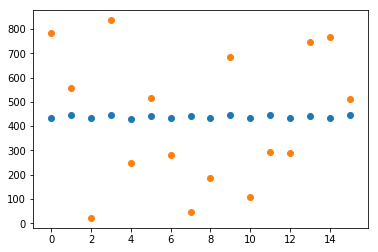

In [199]:
plot_preds()

MSE: 751544.98852
Correlation [ 2870736.41892025]


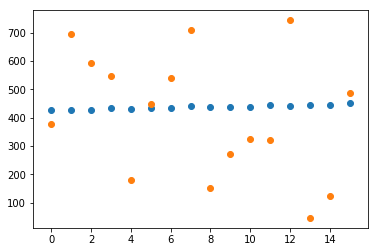

In [202]:
ms = np.random.randint(0, 1000, size=(16, 1))
plot_preds()

In [277]:
memory_length = 9 # 2 for prev step
input_length = 3
train_size = 500
learning_rate = 1e-3

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [batch_size, input_length])
y = tf.placeholder(tf.float32, [batch_size, 1])
m = tf.placeholder(tf.float32, [memory_length, 1])
w1 = tf.Variable(tf.random_normal((input_length, memory_length), stddev=.1))
b1 = tf.Variable(tf.zeros((memory_length)))
w2 = tf.Variable(tf.random_normal((memory_length, memory_length), stddev=.1))
b2 = tf.Variable(tf.zeros((memory_length)))

a1 = tf.nn.relu(tf.matmul(x, w1) + b1)
a2 = tf.nn.softmax(tf.matmul(a1, w2) + b2)
out = tf.tensordot(a2, m, 1)

loss = tf.losses.mean_squared_error(y, out)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
minimize = optimizer.minimize(loss)

tr_loss, n = {}, 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        #if i % 1000 == 0:
        ms = np.random.randint(0, 1000, size=(memory_length, 1)) 
        xs = np.random.uniform(0, 3, size=(train_size, input_length))
        ys = ms[np.floor(xs.sum(1)).astype('int')]
        x_batch = xs[n:n + batch_size]
        y_batch = np.array(ys[n:n + batch_size]).reshape(-1, 1)    
        n = (n + batch_size) % (train_size - batch_size)
        (tr_loss[i], _) = sess.run([loss, minimize], feed_dict={x: x_batch, y: y_batch, m: ms})
        if i % 1000 == 0:
            weights = sess.run([w1, b1, w2, b2])
            print(i, tr_loss[i], weights)

0 63911.1 [array([[-0.0606962 ,  0.00228077, -0.00945104,  0.00781851,  0.00859312,
         0.0254439 , -0.0992059 , -0.05868071, -0.04800843],
       [ 0.12809315, -0.02520901, -0.07734205, -0.18426453, -0.24857533,
        -0.03826084, -0.09245633, -0.0390297 , -0.04427392],
       [-0.12076395,  0.0924149 , -0.04652423, -0.21474269,  0.05117282,
        -0.10159727, -0.06893701,  0.07656697,  0.11752055]], dtype=float32), array([-0.001, -0.001,  0.   ,  0.   , -0.001,  0.001,  0.   ,  0.001,
        0.001], dtype=float32), array([[-0.04021638,  0.07521019,  0.07002664, -0.05823661,  0.00922497,
         0.08350418, -0.06884985,  0.00180423, -0.05544532],
       [ 0.00176565,  0.03824569, -0.10895612,  0.05624956,  0.15419382,
        -0.02487894, -0.08578234, -0.27901646,  0.14156914],
       [-0.02315182, -0.05904068, -0.01525536,  0.08508341,  0.07342952,
        -0.01319189, -0.14837569,  0.14569464, -0.13728766],
       [-0.07661819, -0.0235022 , -0.01299979, -0.00355304,  0.04

5000 58598.4 [array([[  9.72603023e-01,   1.03276134e+00,  -9.45103541e-03,
         -1.03390438e-03,  -2.21822470e-01,  -2.89940327e-01,
         -9.92059037e-02,  -4.40046489e-01,   8.27392399e-01],
       [  1.03109157e+00,   9.20404494e-01,  -7.73420483e-02,
         -1.93116829e-01,  -5.03689229e-01,  -2.18408987e-01,
         -9.24563333e-02,  -3.47189963e-01,   7.48455644e-01],
       [  9.19786692e-01,   1.04570985e+00,  -4.65242267e-02,
         -2.23594978e-01,  -2.10053667e-01,  -3.84522319e-01,
         -6.89370111e-02,  -3.97592425e-01,   8.72468531e-01]], dtype=float32), array([-1.31123698, -1.51949298,  0.        , -0.00885241,  2.14087868,
        1.99050331,  0.        ,  2.60288858, -1.25841725], dtype=float32), array([[ -6.51086748e-01,  -1.30089724e+00,  -4.63470340e-01,
         -1.59540012e-01,   1.90166697e-01,   5.55380762e-01,
          4.75727916e-01,  -4.62205857e-01,  -7.32848227e-01],
       [ -6.05314791e-01,  -1.73035681e+00,  -8.68760586e-01,
         -1

9000 10683.9 [array([[  1.29982495e+00,   1.42365861e+00,  -9.45103541e-03,
         -1.03390438e-03,  -4.96662825e-01,  -4.72785294e-01,
         -9.92059037e-02,  -5.74315429e-01,   1.15808260e+00],
       [  1.33499146e+00,   1.37609076e+00,  -7.73420483e-02,
         -1.93116829e-01,  -5.09134233e-01,  -4.58658397e-01,
         -9.24563333e-02,  -5.56487083e-01,   1.15727174e+00],
       [  1.27582681e+00,   1.42908847e+00,  -4.65242267e-02,
         -2.23594978e-01,  -4.92459565e-01,  -4.74213153e-01,
         -6.89370111e-02,  -5.65943778e-01,   1.17112339e+00]], dtype=float32), array([-2.21151447, -2.40329218,  0.        , -0.00885241,  3.18067241,
        2.98226404,  0.        ,  3.60511065, -1.9920485 ], dtype=float32), array([[ -7.01009810e-01,  -2.38262153e+00,  -9.09080029e-01,
         -3.14729601e-01,   1.91807225e-01,   6.58967137e-01,
          5.66418290e-01,  -5.13593376e-01,  -7.81828225e-01],
       [ -6.87935293e-01,  -2.99859190e+00,  -1.37664509e+00,
         -3

13000 39032.5 [array([[  1.46890533e+00,   1.59996200e+00,  -9.45103541e-03,
         -1.03390438e-03,  -5.89949787e-01,  -5.53704619e-01,
         -9.92059037e-02,  -6.55929625e-01,   1.32630980e+00],
       [  1.49615097e+00,   1.57388020e+00,  -7.73420483e-02,
         -1.93116829e-01,  -5.95715404e-01,  -5.56161880e-01,
         -9.24563333e-02,  -6.56860232e-01,   1.34460294e+00],
       [  1.46681249e+00,   1.61334407e+00,  -4.65242267e-02,
         -2.23594978e-01,  -5.89892328e-01,  -5.54821253e-01,
         -6.89370111e-02,  -6.55331790e-01,   1.33962500e+00]], dtype=float32), array([-2.69071913, -2.87320733,  0.        , -0.00885241,  3.69401884,
        3.46354485,  0.        ,  4.09320116, -2.40058899], dtype=float32), array([[ -7.45833695e-01,  -3.48134398e+00,  -1.32189739e+00,
         -4.75165725e-01,   1.79307356e-01,   7.30267167e-01,
          6.17980301e-01,  -5.61700344e-01,  -8.29696178e-01],
       [ -7.67628431e-01,  -4.11811018e+00,  -1.79030049e+00,
         -

17000 27828.6 [array([[  1.59756708e+00,   1.73082471e+00,  -9.45103541e-03,
         -1.03390438e-03,  -6.46478891e-01,  -6.06024265e-01,
         -9.92059037e-02,  -7.09874570e-01,   1.45386887e+00],
       [  1.59920335e+00,   1.69260740e+00,  -7.73420483e-02,
         -1.93116829e-01,  -6.41159713e-01,  -6.01110399e-01,
         -9.24563333e-02,  -7.04151869e-01,   1.45743668e+00],
       [  1.58195305e+00,   1.72555590e+00,  -4.65242267e-02,
         -2.23594978e-01,  -6.46303535e-01,  -6.07148111e-01,
         -6.89370111e-02,  -7.09415019e-01,   1.45679295e+00]], dtype=float32), array([-2.96319103, -3.14798832,  0.        , -0.00885241,  3.98476815,
        3.73868251,  0.        ,  4.37550259, -2.6430316 ], dtype=float32), array([[ -8.17857563e-01,  -4.59237194e+00,  -1.64568472e+00,
         -6.00249290e-01,   1.66100383e-01,   7.77915835e-01,
          6.51841462e-01,  -6.36711419e-01,  -9.05966163e-01],
       [ -8.95520329e-01,  -5.16577101e+00,  -2.10169148e+00,
         -

21000 13552.0 [array([[  1.66170466e+00,   1.79233086e+00,  -9.45103541e-03,
         -1.03390438e-03,  -6.84111118e-01,  -6.42202377e-01,
         -9.92059037e-02,  -7.46676326e-01,   1.51467133e+00],
       [  1.66857815e+00,   1.77190602e+00,  -7.73420483e-02,
         -1.93116829e-01,  -6.78880990e-01,  -6.36960447e-01,
         -9.24563333e-02,  -7.42129683e-01,   1.53346157e+00],
       [  1.65338492e+00,   1.79381287e+00,  -4.65242267e-02,
         -2.23594978e-01,  -6.88620389e-01,  -6.47603393e-01,
         -6.89370111e-02,  -7.52004445e-01,   1.52723646e+00]], dtype=float32), array([-3.17424631, -3.3646245 ,  0.        , -0.00885241,  4.19090986,
        3.93470287,  0.        ,  4.57715702, -2.83904099], dtype=float32), array([[ -9.03152823e-01,  -5.56930304e+00,  -1.90255487e+00,
         -6.97010338e-01,   1.52413324e-01,   8.19391847e-01,
          6.68532610e-01,  -7.20252693e-01,  -9.91013050e-01],
       [ -1.04591978e+00,  -6.02432823e+00,  -2.34817743e+00,
         -

25000 7680.12 [array([[  1.72989416e+00,   1.86114645e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.10453689e-01,  -6.67644322e-01,
         -9.92059037e-02,  -7.73735940e-01,   1.58245277e+00],
       [  1.74112666e+00,   1.84352410e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.15177715e-01,  -6.71746969e-01,
         -9.24563333e-02,  -7.77923763e-01,   1.59182703e+00],
       [  1.73834634e+00,   1.87302768e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.08847225e-01,  -6.66241527e-01,
         -6.89370111e-02,  -7.72036374e-01,   1.60403752e+00]], dtype=float32), array([-3.31950545, -3.52028298,  0.        , -0.00885241,  4.34134579,
        4.07894707,  0.        ,  4.72586584, -2.98318529], dtype=float32), array([[ -9.95913804e-01,  -6.53217554e+00,  -2.12681508e+00,
         -7.91803896e-01,   1.41568229e-01,   8.62073720e-01,
          6.69430137e-01,  -8.13589454e-01,  -1.08396792e+00],
       [ -1.20789051e+00,  -6.84582806e+00,  -2.56405640e+00,
         -

29000 53793.5 [array([[  1.77689648e+00,   1.91250432e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.34381795e-01,  -6.90989673e-01,
         -9.92059037e-02,  -7.97470093e-01,   1.63754308e+00],
       [  1.80325806e+00,   1.90201986e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.33363807e-01,  -6.90635681e-01,
         -9.24563333e-02,  -7.97114074e-01,   1.63663197e+00],
       [  1.77410805e+00,   1.91834939e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.29883194e-01,  -6.85280859e-01,
         -6.89370111e-02,  -7.92017639e-01,   1.65552342e+00]], dtype=float32), array([-3.45193791, -3.66065145,  0.        , -0.00885241,  4.46135664,
        4.19423389,  0.        ,  4.84498787, -3.11440659], dtype=float32), array([[ -1.09076297e+00,  -7.43275118e+00,  -2.33343172e+00,
         -8.66782129e-01,   1.22256368e-01,   8.89373004e-01,
          6.77464068e-01,  -9.03744280e-01,  -1.17448688e+00],
       [ -1.37146902e+00,  -7.60016346e+00,  -2.76444674e+00,
         -

33000 4402.51 [array([[  1.83421099e+00,   1.97623038e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.50712872e-01,  -7.06506252e-01,
         -9.92059037e-02,  -8.13612163e-01,   1.70331419e+00],
       [  1.84659231e+00,   1.95583844e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.50085115e-01,  -7.05996692e-01,
         -9.24563333e-02,  -8.13389361e-01,   1.68793917e+00],
       [  1.83201027e+00,   1.97009981e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.46859312e-01,  -7.02937841e-01,
         -6.89370111e-02,  -8.10184479e-01,   1.70309651e+00]], dtype=float32), array([-3.55085444, -3.77009082,  0.        , -0.00885241,  4.56452894,
        4.29330158,  0.        ,  4.94753695, -3.2188797 ], dtype=float32), array([[ -1.18592262e+00,  -8.35784245e+00,  -2.51333976e+00,
         -9.43462670e-01,   9.84142274e-02,   9.12332594e-01,
          6.86543882e-01,  -9.95797455e-01,  -1.26932752e+00],
       [ -1.53397882e+00,  -8.37229824e+00,  -2.93821573e+00,
         -

37000 22230.2 [array([[  1.86799669e+00,   2.00879097e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.60764182e-01,  -7.16249824e-01,
         -9.92059037e-02,  -8.24212551e-01,   1.73732936e+00],
       [  1.88255882e+00,   1.99773717e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.65065730e-01,  -7.20338702e-01,
         -9.24563333e-02,  -8.28141868e-01,   1.72915232e+00],
       [  1.87980747e+00,   2.02315855e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.65556872e-01,  -7.20336735e-01,
         -6.89370111e-02,  -8.28740299e-01,   1.75409269e+00]], dtype=float32), array([-3.64209628, -3.87271142,  0.        , -0.00885241,  4.65099192,
        4.37713814,  0.        ,  5.03390074, -3.31726789], dtype=float32), array([[ -1.27889347e+00,  -9.22249222e+00,  -2.68510079e+00,
         -1.01485145e+00,   9.23296139e-02,   9.31881428e-01,
          6.88788176e-01,  -1.08499253e+00,  -1.36173761e+00],
       [ -1.69104230e+00,  -9.08528042e+00,  -3.10531402e+00,
         -

41000 3857.59 [array([[  1.90564811e+00,   2.04858780e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.77587116e-01,  -7.32151508e-01,
         -9.92059037e-02,  -8.40768874e-01,   1.77797544e+00],
       [  1.91738749e+00,   2.04631209e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.78673291e-01,  -7.33334720e-01,
         -9.24563333e-02,  -8.41887295e-01,   1.77601051e+00],
       [  1.90345204e+00,   2.04559875e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.74775922e-01,  -7.29444444e-01,
         -6.89370111e-02,  -8.37787628e-01,   1.77500069e+00]], dtype=float32), array([-3.72856855, -3.96362686,  0.        , -0.00885241,  4.72460461,
        4.44853258,  0.        ,  5.10767651, -3.40531826], dtype=float32), array([[ -1.37007654e+00,  -1.00052996e+01,  -2.83511519e+00,
         -1.07864547e+00,   8.17048550e-02,   9.50355411e-01,
          6.91016138e-01,  -1.17744100e+00,  -1.45264709e+00],
       [ -1.84357333e+00,  -9.74204063e+00,  -3.25144577e+00,
         -

45000 4894.58 [array([[  1.94287789e+00,   2.08232808e+00,  -9.45103541e-03,
         -1.03390438e-03,  -7.89550662e-01,  -7.43841052e-01,
         -9.92059037e-02,  -8.53053927e-01,   1.80815244e+00],
       [  1.94066477e+00,   2.07586265e+00,  -7.73420483e-02,
         -1.93116829e-01,  -7.92679548e-01,  -7.46299863e-01,
         -9.24563333e-02,  -8.55861902e-01,   1.80499566e+00],
       [  1.94501925e+00,   2.08745050e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.87448525e-01,  -7.41754472e-01,
         -6.89370111e-02,  -8.50379407e-01,   1.81496894e+00]], dtype=float32), array([-3.79117346, -4.03669786,  0.        , -0.00885241,  4.7917366 ,
        4.51361895,  0.        ,  5.17487288, -3.47834015], dtype=float32), array([[ -1.45995200e+00,  -1.07706642e+01,  -2.97174764e+00,
         -1.13519359e+00,   6.94526285e-02,   9.70329225e-01,
          6.89085782e-01,  -1.26340806e+00,  -1.54219365e+00],
       [ -1.99151945e+00,  -1.03850346e+01,  -3.38418913e+00,
         -

49000 10321.1 [array([[  1.97378409e+00,   2.11951756e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.00108373e-01,  -7.54621387e-01,
         -9.92059037e-02,  -8.63059580e-01,   1.84692073e+00],
       [  1.97221267e+00,   2.11310387e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.02074552e-01,  -7.55351543e-01,
         -9.24563333e-02,  -8.64784658e-01,   1.84038556e+00],
       [  1.96722496e+00,   2.11748385e+00,  -4.65242267e-02,
         -2.23594978e-01,  -7.99162090e-01,  -7.52495348e-01,
         -6.89370111e-02,  -8.62118602e-01,   1.84826481e+00]], dtype=float32), array([-3.84880686, -4.10098743,  0.        , -0.00885241,  4.85169077,
        4.57187986,  0.        ,  5.2353034 , -3.5432725 ], dtype=float32), array([[ -1.54861283e+00,  -1.15149460e+01,  -3.10848212e+00,
         -1.18047071e+00,   5.08764386e-02,   9.76227045e-01,
          7.00123072e-01,  -1.34738815e+00,  -1.62913907e+00],
       [ -2.13045883e+00,  -1.10056267e+01,  -3.51804614e+00,
         -

53000 6481.75 [array([[  1.99768019e+00,   2.13380456e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.09053779e-01,  -7.63582706e-01,
         -9.92059037e-02,  -8.72339487e-01,   1.85220158e+00],
       [  2.00397229e+00,   2.15305495e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.06471884e-01,  -7.59249568e-01,
         -9.24563333e-02,  -8.69599581e-01,   1.88254035e+00],
       [  1.99196398e+00,   2.14206004e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.05957317e-01,  -7.59702325e-01,
         -6.89370111e-02,  -8.69629681e-01,   1.87063336e+00]], dtype=float32), array([-3.91345286, -4.17624235,  0.        , -0.00885241,  4.91100645,
        4.62940741,  0.        ,  5.29432964, -3.62075019], dtype=float32), array([[ -1.63043690e+00,  -1.21863050e+01,  -3.22912812e+00,
         -1.24335063e+00,   3.58656421e-02,   9.98199880e-01,
          6.94860399e-01,  -1.43198061e+00,  -1.70850050e+00],
       [ -2.24086833e+00,  -1.15614281e+01,  -3.63620710e+00,
         -

57000 11761.8 [array([[  2.02745461e+00,   2.17207384e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.18373680e-01,  -7.71480978e-01,
         -9.92059037e-02,  -8.81414473e-01,   1.89252877e+00],
       [  2.01333952e+00,   2.16056490e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.20977509e-01,  -7.74674237e-01,
         -9.24563333e-02,  -8.84447396e-01,   1.88698614e+00],
       [  2.01735210e+00,   2.16826630e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.18906248e-01,  -7.72172987e-01,
         -6.89370111e-02,  -8.82630646e-01,   1.89660704e+00]], dtype=float32), array([-3.96571159, -4.23551512,  0.        , -0.00885241,  4.96069384,
        4.67771435,  0.        ,  5.3439908 , -3.6805892 ], dtype=float32), array([[ -1.69013369e+00,  -1.28738642e+01,  -3.34547806e+00,
         -1.28814912e+00,   2.90086325e-02,   1.01175022e+00,
          6.92951381e-01,  -1.49574995e+00,  -1.77404356e+00],
       [ -2.30925274e+00,  -1.21501904e+01,  -3.75053859e+00,
         -

61000 12615.8 [array([[  2.04628015e+00,   2.19545197e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.30003977e-01,  -7.82707572e-01,
         -9.92059037e-02,  -8.92911375e-01,   1.92179811e+00],
       [  2.05248570e+00,   2.20002031e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.25405240e-01,  -7.78710485e-01,
         -9.24563333e-02,  -8.89492393e-01,   1.92515099e+00],
       [  2.04254794e+00,   2.19774675e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.27705503e-01,  -7.80773699e-01,
         -6.89370111e-02,  -8.90861690e-01,   1.92603695e+00]], dtype=float32), array([-4.00072432, -4.28009892,  0.        , -0.00885241,  5.00923252,
        4.72527027,  0.        ,  5.39276505, -3.7256422 ], dtype=float32), array([[ -1.72903240e+00,  -1.35532255e+01,  -3.46023035e+00,
         -1.33265316e+00,   1.90550946e-02,   1.01941848e+00,
          6.97618663e-01,  -1.53817070e+00,  -1.81492472e+00],
       [ -2.35138321e+00,  -1.27312784e+01,  -3.86336112e+00,
         -

65000 7971.74 [array([[  2.05736732e+00,   2.20767927e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.35726023e-01,  -7.88510740e-01,
         -9.92059037e-02,  -8.98784041e-01,   1.93268037e+00],
       [  2.06375647e+00,   2.21136308e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.35105240e-01,  -7.88231015e-01,
         -9.24563333e-02,  -8.98826718e-01,   1.93518424e+00],
       [  2.06264591e+00,   2.21867776e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.34400177e-01,  -7.87685573e-01,
         -6.89370111e-02,  -8.97909462e-01,   1.94695783e+00]], dtype=float32), array([-4.05492783, -4.34088182,  0.        , -0.00885241,  5.05575562,
        4.77023697,  0.        ,  5.43933582, -3.78808093], dtype=float32), array([[ -1.75725377e+00,  -1.41235132e+01,  -3.54489350e+00,
         -1.37781012e+00,   5.52026182e-03,   1.03334880e+00,
          6.95876956e-01,  -1.56577444e+00,  -1.84390199e+00],
       [ -2.38171983e+00,  -1.32505674e+01,  -3.94684124e+00,
         -

69000 5253.59 [array([[  2.08445477e+00,   2.23792434e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.42209339e-01,  -7.95187056e-01,
         -9.92059037e-02,  -9.05562401e-01,   1.95965445e+00],
       [  2.08387780e+00,   2.24308491e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.40673387e-01,  -7.93192685e-01,
         -9.24563333e-02,  -9.04051363e-01,   1.97117257e+00],
       [  2.08468246e+00,   2.24196482e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.40099573e-01,  -7.92808235e-01,
         -6.89370111e-02,  -9.03592050e-01,   1.96956277e+00]], dtype=float32), array([-4.08787346, -4.37798548,  0.        , -0.00885241,  5.09849119,
        4.81223536,  0.        ,  5.48222017, -3.8287704 ], dtype=float32), array([[ -1.77869368e+00,  -1.47090368e+01,  -3.64566875e+00,
         -1.42002344e+00,  -4.34307940e-03,   1.03901017e+00,
          7.01712370e-01,  -1.58861911e+00,  -1.86637235e+00],
       [ -2.40480137e+00,  -1.37633162e+01,  -4.04631042e+00,
         -

73000 23224.9 [array([[  2.09930110e+00,   2.26341462e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.45245361e-01,  -7.97826469e-01,
         -9.92059037e-02,  -9.08965647e-01,   1.99307096e+00],
       [  2.10170150e+00,   2.26061583e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.51662755e-01,  -8.04784119e-01,
         -9.24563333e-02,  -9.15545285e-01,   1.98902333e+00],
       [  2.10355449e+00,   2.26728392e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.46928775e-01,  -7.99860716e-01,
         -6.89370111e-02,  -9.10545170e-01,   1.99762046e+00]], dtype=float32), array([-4.13073492, -4.42438507,  0.        , -0.00885241,  5.13563538,
        4.84811831,  0.        ,  5.51915026, -3.87301111], dtype=float32), array([[ -1.79859400e+00,  -1.52551031e+01,  -3.73846912e+00,
         -1.46307909e+00,  -2.29564738e-02,   1.04328430e+00,
          7.10031986e-01,  -1.60915709e+00,  -1.88673449e+00],
       [ -2.42624927e+00,  -1.42399597e+01,  -4.13757277e+00,
         -

77000 3086.19 [array([[  2.11042595e+00,   2.27271605e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.53413165e-01,  -8.05350423e-01,
         -9.92059037e-02,  -9.16768491e-01,   2.00015616e+00],
       [  2.11969233e+00,   2.27941918e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.52535963e-01,  -8.05269122e-01,
         -9.24563333e-02,  -9.16273236e-01,   2.00791740e+00],
       [  2.12010622e+00,   2.28075361e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.57689977e-01,  -8.09857607e-01,
         -6.89370111e-02,  -9.20988858e-01,   2.00749159e+00]], dtype=float32), array([-4.16897821, -4.47210026,  0.        , -0.00885241,  5.17555428,
        4.88766432,  0.        ,  5.55948639, -3.92416811], dtype=float32), array([[ -1.81604910e+00,  -1.58272858e+01,  -3.83142161e+00,
         -1.49785924e+00,  -2.29824521e-02,   1.05569184e+00,
          7.05177724e-01,  -1.62606990e+00,  -1.90441263e+00],
       [ -2.44507289e+00,  -1.47369938e+01,  -4.22910833e+00,
         -

81000 3314.17 [array([[  2.13336492e+00,   2.29148412e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.63538086e-01,  -8.16663921e-01,
         -9.92059037e-02,  -9.27385747e-01,   2.01592374e+00],
       [  2.13654184e+00,   2.30044389e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.56598139e-01,  -8.08902562e-01,
         -9.24563333e-02,  -9.19835031e-01,   2.03189993e+00],
       [  2.11706853e+00,   2.28204083e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.62560272e-01,  -8.14619005e-01,
         -6.89370111e-02,  -9.26165760e-01,   2.01081204e+00]], dtype=float32), array([-4.19739199, -4.50763083,  0.        , -0.00885241,  5.2139349 ,
        4.92465305,  0.        ,  5.59783077, -3.96229506], dtype=float32), array([[ -1.83234465e+00,  -1.63731956e+01,  -3.89778280e+00,
         -1.52947605e+00,  -4.09024246e-02,   1.05852389e+00,
          7.11965680e-01,  -1.64267099e+00,  -1.92017937e+00],
       [ -2.46262407e+00,  -1.52279606e+01,  -4.29440212e+00,
         -

85000 53249.4 [array([[  2.14545012e+00,   2.30387163e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.64087760e-01,  -8.16806793e-01,
         -9.92059037e-02,  -9.27799046e-01,   2.02874136e+00],
       [  2.13753939e+00,   2.30776262e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.64819229e-01,  -8.16537321e-01,
         -9.24563333e-02,  -9.28071618e-01,   2.04350543e+00],
       [  2.14265347e+00,   2.31098890e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.67945910e-01,  -8.20309460e-01,
         -6.89370111e-02,  -9.31607366e-01,   2.04033971e+00]], dtype=float32), array([-4.22802353, -4.54209518,  0.        , -0.00885241,  5.24933958,
        4.95949793,  0.        ,  5.63325262, -3.99702525], dtype=float32), array([[ -1.84671950e+00,  -1.68608189e+01,  -3.97805572e+00,
         -1.56708467e+00,  -4.25461568e-02,   1.06295288e+00,
          7.14748800e-01,  -1.65777862e+00,  -1.93528497e+00],
       [ -2.47811818e+00,  -1.56783953e+01,  -4.37373972e+00,
         -

89000 15328.3 [array([[  2.16152954e+00,   2.32290173e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.72186601e-01,  -8.24166954e-01,
         -9.92059037e-02,  -9.35515583e-01,   2.04851675e+00],
       [  2.15869856e+00,   2.32950616e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.73166263e-01,  -8.25127661e-01,
         -9.24563333e-02,  -9.36562538e-01,   2.06528258e+00],
       [  2.16021347e+00,   2.33179736e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.70416582e-01,  -8.22577059e-01,
         -6.89370111e-02,  -9.34214532e-01,   2.06170249e+00]], dtype=float32), array([-4.2555089 , -4.57431555,  0.        , -0.00885241,  5.27941036,
        4.98917866,  0.        ,  5.66342545, -4.03044319], dtype=float32), array([[ -1.86126077e+00,  -1.72955742e+01,  -4.06354952e+00,
         -1.59975314e+00,  -5.90529181e-02,   1.07365084e+00,
          7.13666201e-01,  -1.67167628e+00,  -1.95008922e+00],
       [ -2.49381137e+00,  -1.60689831e+01,  -4.45827198e+00,
         -

93000 8046.95 [array([[  2.17445707e+00,   2.33959150e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.74944150e-01,  -8.27345729e-01,
         -9.92059037e-02,  -9.38410580e-01,   2.06618428e+00],
       [  2.17151332e+00,   2.34214973e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.79070163e-01,  -8.30795348e-01,
         -9.24563333e-02,  -9.42605495e-01,   2.07602763e+00],
       [  2.17313170e+00,   2.34590030e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.76941025e-01,  -8.28587234e-01,
         -6.89370111e-02,  -9.40438628e-01,   2.07622552e+00]], dtype=float32), array([-4.28001404, -4.60453415,  0.        , -0.00885241,  5.31114817,
        5.02029085,  0.        ,  5.69519424, -4.06376219], dtype=float32), array([[ -1.87480533e+00,  -1.77938519e+01,  -4.12631464e+00,
         -1.63948274e+00,  -6.22498319e-02,   1.07746816e+00,
          7.17156708e-01,  -1.68622530e+00,  -1.96466982e+00],
       [ -2.50841498e+00,  -1.65200996e+01,  -4.52003479e+00,
         -

97000 18485.8 [array([[  2.19109249e+00,   2.35536361e+00,  -9.45103541e-03,
         -1.03390438e-03,  -8.82373691e-01,  -8.34897280e-01,
         -9.92059037e-02,  -9.45948064e-01,   2.07995415e+00],
       [  2.18649817e+00,   2.35963464e+00,  -7.73420483e-02,
         -1.93116829e-01,  -8.80508423e-01,  -8.32185805e-01,
         -9.24563333e-02,  -9.43784952e-01,   2.09492350e+00],
       [  2.17992067e+00,   2.35368586e+00,  -4.65242267e-02,
         -2.23594978e-01,  -8.81464064e-01,  -8.33143175e-01,
         -6.89370111e-02,  -9.44883525e-01,   2.08537149e+00]], dtype=float32), array([-4.30665445, -4.63704205,  0.        , -0.00885241,  5.34253168,
        5.05094337,  0.        ,  5.72664738, -4.0980525 ], dtype=float32), array([[ -1.88818872e+00,  -1.82724972e+01,  -4.20001030e+00,
         -1.66192138e+00,  -7.79420808e-02,   1.08333814e+00,
          7.19507694e-01,  -1.69961619e+00,  -1.97731721e+00],
       [ -2.52285028e+00,  -1.69681492e+01,  -4.59293461e+00,
         -

A) Note that in the experiment above, it took ~10000 iterations to reach good values for w. In the end, the values for w are optimal. Now, what if we change the memory every three iterations instead of changing the memory every thousand iterations? 
We need ~4000 iterations to reach acceptable values for w. (If you keep trying values, you will notice that it doesn't matter that much if we change the memory once every two iterations or once every hundred iterations: we reach the identity in ~4000 iterations.)

B) Interestingly, adding a bias term only makes things worse. It could be because it has more computational power, and that makes the nn overfit to one specific memory, instead of generalizing to the fact that memories change.

In [237]:
softargmax(w_final.dot([0, 1]) + b_final)b

array([ 0.27570458,  0.72429542])

Let's see what happens if we have arbitrary values for the indices of memories.

So the question now is what do we ask the nn to do. It has the memory, and our desired output is a function of the memory. It also has to be a function of the input. Otherwise, it would be deterministic. So, what function on the input do we want? It could be something like reading mnist digits and retrieving a memory depending on the mnist number.

In [345]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)

In [346]:
ms = np.random.randint(0, 1000, size=(10, 1))
m_train = ms[y_train]

In [350]:
memory_length = 10
input_length = 784
train_size = 500
learning_rate = 1e-4
hidden_size = 100

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [batch_size, input_length])
y = tf.placeholder(tf.float32, [batch_size, 1])
m = tf.placeholder(tf.float32, [memory_length, 1])
w1 = tf.Variable(tf.random_normal((input_length, hidden_size), stddev=.01))
b1 = tf.Variable(tf.zeros((hidden_size)))
w2 = tf.Variable(tf.random_normal((hidden_size, memory_length), stddev=.01))
b2 = tf.Variable(tf.zeros((memory_length)))

a1 = tf.nn.relu(tf.matmul(x, w1) + b1)
a2 = tf.nn.softmax(tf.matmul(a1, w2) + b2)
out = tf.tensordot(a2, m, 1)
loss = tf.losses.mean_squared_error(y, out)
#V2
#a2 = tf.matmul(a1, w2) + b2
#loss = tf.losses.softmax_cross_entropy(y, a2)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
minimize = optimizer.minimize(loss)

tr_loss, n = {}, 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        x_batch = x_train[n:n + batch_size]
        y_batch = np.array(m_train[n:n + batch_size]).reshape(-1, 1)    
        n = (n + batch_size) % (train_size - batch_size)
    
        (tr_loss[i], _) = sess.run([loss, minimize], feed_dict={x: x_batch, y: y_batch, m: ms})
        if i % 3 == 0:
            ms = np.random.randint(0, 1000, size=(10, 1))
            m_train = ms[y_train]
        if i % 100 == 0:
            print(f'Iteration {i}. loss {tr_loss[i]}')
            (a2s) = sess.run([a2], feed_dict={x: x_test[:128]})
            print('accuracy', np.mean(y_test[:128] == np.argmax(a2s[0], axis=1)))

Iteration 0. loss 73427.1875
accuracy 0.15625
Iteration 100. loss 16538.76953125
accuracy 0.7890625
Iteration 200. loss 8740.9384765625
accuracy 0.7421875
Iteration 300. loss 5805.515625
accuracy 0.703125
Iteration 400. loss 289.88397216796875
accuracy 0.828125
Iteration 500. loss 681.7474975585938
accuracy 0.8359375
Iteration 600. loss 65.23436737060547
accuracy 0.828125
Iteration 700. loss 95.19096374511719
accuracy 0.8203125
Iteration 800. loss 74.06330108642578
accuracy 0.8203125
Iteration 900. loss 4.840771675109863
accuracy 0.8359375
Iteration 1000. loss 77.21870422363281
accuracy 0.8515625
Iteration 1100. loss 53.76578140258789
accuracy 0.84375
Iteration 1200. loss 22.459138870239258
accuracy 0.84375
Iteration 1300. loss 30.53400421142578
accuracy 0.84375
Iteration 1400. loss 24.286518096923828
accuracy 0.84375
Iteration 1500. loss 13.879364967346191
accuracy 0.84375
Iteration 1600. loss 10.923752784729004
accuracy 0.8359375
Iteration 1700. loss 20.207233428955078
accuracy 0.835

Iteration 14000. loss 0.004193868022412062
accuracy 0.859375
Iteration 14100. loss 0.005662155337631702
accuracy 0.859375
Iteration 14200. loss 0.012571534141898155
accuracy 0.859375
Iteration 14300. loss 0.005933924578130245
accuracy 0.859375
Iteration 14400. loss 0.002988504245877266
accuracy 0.859375
Iteration 14500. loss 0.009182171896100044
accuracy 0.859375
Iteration 14600. loss 0.0031831141095608473
accuracy 0.859375
Iteration 14700. loss 0.002117578871548176
accuracy 0.859375
Iteration 14800. loss 0.002786056138575077
accuracy 0.859375
Iteration 14900. loss 0.0024256743490695953
accuracy 0.859375
Iteration 15000. loss 0.004864485003054142
accuracy 0.859375
Iteration 15100. loss 0.0036202932242304087
accuracy 0.859375
Iteration 15200. loss 0.001279588439501822
accuracy 0.859375
Iteration 15300. loss 0.0020516824442893267
accuracy 0.859375
Iteration 15400. loss 0.005528993904590607
accuracy 0.859375
Iteration 15500. loss 0.003961182199418545
accuracy 0.859375
Iteration 15600. los

Iteration 27200. loss 1.0322581147192977e-05
accuracy 0.84375
Iteration 27300. loss 6.731993380526546e-06
accuracy 0.84375
Iteration 27400. loss 8.237911970354617e-06
accuracy 0.84375
Iteration 27500. loss 9.154813596978784e-06
accuracy 0.84375
Iteration 27600. loss 3.292344445071649e-06
accuracy 0.84375
Iteration 27700. loss 2.663096893229522e-06
accuracy 0.84375
Iteration 27800. loss 2.6861762307817116e-06
accuracy 0.84375
Iteration 27900. loss 1.6812957255751826e-05
accuracy 0.84375
Iteration 28000. loss 2.2103340597823262e-06
accuracy 0.84375
Iteration 28100. loss 1.834780050558038e-06
accuracy 0.84375
Iteration 28200. loss 2.9528378036047798e-06
accuracy 0.84375
Iteration 28300. loss 5.990295449009864e-06
accuracy 0.84375
Iteration 28400. loss 1.0267471225233749e-05
accuracy 0.84375
Iteration 28500. loss 1.8424643712933175e-06
accuracy 0.84375
Iteration 28600. loss 3.107557859038934e-06
accuracy 0.84375
Iteration 28700. loss 2.3627944756299257e-06
accuracy 0.84375
Iteration 28800.

Iteration 40300. loss 3.538378479106541e-09
accuracy 0.8515625
Iteration 40400. loss 3.470631781965494e-09
accuracy 0.8515625
Iteration 40500. loss 3.356035449542105e-09
accuracy 0.8515625
Iteration 40600. loss 4.99130692332983e-09
accuracy 0.8515625
Iteration 40700. loss 6.329628376988694e-09
accuracy 0.8515625
Iteration 40800. loss 3.1250237952917814e-09
accuracy 0.8515625
Iteration 40900. loss 9.09403752302751e-09
accuracy 0.8515625
Iteration 41000. loss 2.541582944104448e-09
accuracy 0.8515625
Iteration 41100. loss 4.177763912593946e-09
accuracy 0.8515625
Iteration 41200. loss 5.759375198977068e-09
accuracy 0.8515625
Iteration 41300. loss 5.548063342075693e-09
accuracy 0.8515625
Iteration 41400. loss 8.1478219726705e-09
accuracy 0.8515625
Iteration 41500. loss 3.574314177967608e-09
accuracy 0.8515625
Iteration 41600. loss 4.4037733459845185e-09
accuracy 0.8515625
Iteration 41700. loss 2.737237991823349e-09
accuracy 0.8515625
Iteration 41800. loss 2.7655460144160315e-09
accuracy 0.8

KeyboardInterrupt: 

Training the same nn without the memory lookup (ie, just to recongize mnist digits) takes 600 iterations to reach an accuracy of .89. However, if we use the memory module, it takes 1000 iterations to reach .85 (and 17000 to reach .87)

Let's try to make some task where the memory module makes sense. One place where it seems useful is if we need to remember a big chunk of information, and the thing that trigers it is small. For instance, we can have input-output pairs where the input has four dimensions and the output has 16 dimensions. 


One question is, how do we use our memories? One way could be that we start with one thought and we have a filter (based on the thought we want to reach.) Then, we visit other thoughts that are near the starting thought. And we apply the filter, to keep one/k thoughts. And we continue the process. It seems we can easily check if a thought is true, but we can't come up with the thought if we want to. For instance, what did you do yesterday morning? We probably take some time to remember, but when we do remember, we are pretty sure we know what was the case.

In a way, we are always refining the memory. It's as if we start with a vague memory of what we are looking for and then we refine until finding something interesting. An interesting question is how does that initial, vague memory appear in the first place? As it's low-dimensional, we could have a direct mapping from input to vague memory. 

Note that it's common wisdom that divide and conquer works. that could tell us that the cost of going from one thought to one that is at a distance x compared to the cost of going from that thought to one that is distance 2x, that comparison is 4 times instead of 2 (or at least it's not linear.) Was it linear and it would be the same (in expectation) to try to come up with the solution as a one-step thought from our initial thought as making small steps towards that goal. 

Then, after that direct mapping, we refine our thought to make it clearer.

But yeah, we don't want to have o(n) with n the memories. But we can afford to have o(log n). Notice that the memory could also be used for the processing part. For example, the neural net can decide to store a pattern it saw that lead to then observing an 8, so when it sees the pattern again, it can go the memory and search for that memory.  

Tasks where this could work is when the reasoning of the tasks are similar, but the things with what you have to start with are different. In other words, we need to paramtrize the task solver with different values but the general task solver is the same for every task. 